This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Fml-sicom3a/master?urlpath=lab/tree/notebooks/9_RNN_LSTM/)

Given the computational load, an efficient alternative is to use the UGA's jupyterhub service https://jupyterhub.u-ga.fr/.
In this case, to install tensorflow 2.X, just type

    !pip install --user --upgrade tensorflow

in a code cell, then restart the notebook (or just restart the kernel)

LSTM example on forecasting a scalar temperature value from a vector of past values. 

This Notebook is largely inspired from 
https://www.tensorflow.org/tutorials/structured_data/time_series
which runs under TensorFlow2. 



In [1]:
# import keras
# if tensorflow2, replace by
import os

import numpy as np
import pandas as pd
import tensorflow.keras as keras

# to insure reproductability of different runs
np.random.seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)

# if tensorflow2, replace the two lines above by
from tensorflow import random

random.set_seed(2)

import matplotlib.pyplot as plt

This tutorial uses a weather time series dataset recorded by the Max Planck Institute for Biogeochemistry.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

In [2]:
# zip_path = keras.utils.get_file(
#    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
#    fname='jena_climate_2009_2016.csv.zip', extract= True)
# csv_path, _ = os.path.splitext(zip_path)
# csv_path
# df = pd.read_csv(csv_path)
filename = "jena_climate_2009_2016.csv"
df = pd.read_csv(filename)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


An observation is recorded every 10 mintues. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations.

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use a set of preceding N observations. Thus, you would create a window containing the last N points. For example, 5 days of observation correspond to 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.


##  Forecast a univariate time series

Here, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.


In [3]:
# Extract univariate time series
Temp = df["T (degC)"]
Temp.index = df["Date Time"]
print("the time series contains {} sample".format(Temp.shape[0]))
print("\n First five rows:")
Temp.head()

the time series contains 420551 sample

 First five rows:


Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcbcbe0950>],
      dtype=object)

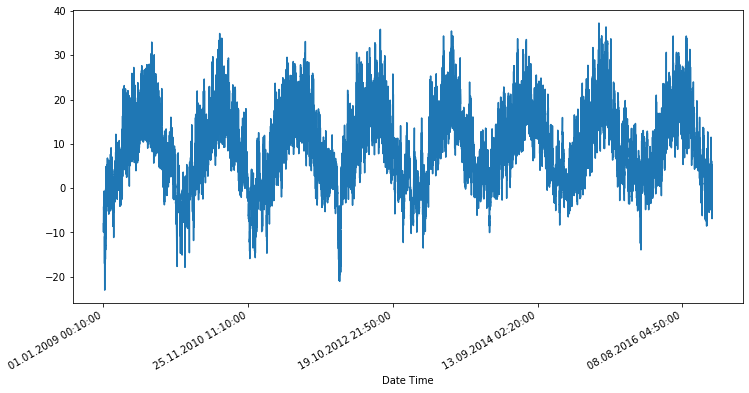

In [4]:
# plot time series
Temp.plot(subplots=True, figsize=(12, 6))

### Rescaling

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1 (if sigmoid activation) or -1 to +1 (if tanh), also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.


In [5]:
from sklearn.preprocessing import MinMaxScaler

data = np.reshape(Temp.values, (420551, 1))
data = data.astype("float32")

scaler = MinMaxScaler(feature_range=(-1, 1))  # compatiblity with choice activation=tanh
data_sc = scaler.fit_transform(data)

print(
    data[:5,]
)
scaler.inverse_transform(data_sc)[
    :5,
]

[[-8.02]
 [-8.41]
 [-8.51]
 [-8.31]
 [-8.27]]


array([[-8.02    ],
       [-8.409999],
       [-8.51    ],
       [-8.31    ],
       [-8.27    ]], dtype=float32)

### Define traning and testing sets

In [6]:
# split into train and test sets
train_size = 300000
test_size = len(data_sc) - train_size
train, test = data_sc[0:train_size, :], data_sc[train_size : len(data_sc), :]
print(len(train), len(test))

300000 120551


The function takes three arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period (default forecast=0); or the next time+forecast period. Note that look_back is defaulted to 1. 

### Rearrange data into a matrix forms

In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, forecast=0):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - forecast - 1):  # current time index is i
        a = dataset[i : (i + look_back), 0]  # a takes i,i+1,...,i+lookback-1
        dataX.append(a)
        dataY.append(
            dataset[i + look_back + forecast, 0]
        )  # from a, predicts at time index i
    return np.array(dataX), np.array(dataY)

On the example below, only 20 past observations are used to predict future  temperature value 6 samples ahead (This correspond to a 1 hour)

In [8]:
# reshape into X=t and Y=t+1
look_back = 20
forecast = 6
trainX, trainY = create_dataset(train, look_back, forecast)
testX, testY = create_dataset(test, look_back, forecast)
trainX.shape
trainY = trainY.reshape((-1, 1))
testY = testY.reshape((-1, 1))

In [9]:
trainX.shape

(299973, 20)

### The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [10]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainX.shape

(299973, 20, 1)

In [11]:
# May be useful to test the code on shorter data set...

# trainX=trainX[:200,:,:]
# trainY=trainY[:200]
# testX=testX[:200,:,:]
# testY=testY[:200]
# trainY.shape

In [12]:
# Save the original datasets
trainX_orig, trainY_orig, testX_orig, testY_orig,= trainX, trainY, testX, testY

## Learn a LSTM model 

A batch method is used during the optization phase. The size of the batches is set here to 256 samples (256 consecutive -in time- vectors X of look_back (=20) numerical values, and correponding outputs Y.

The cell states are initialized at random. Obviously, the paramater shuffle has to be set to shuffle=False, as shuffling the data would destroy all time dependencies that are seeked by the LSTM. 

As by default, cell states are not reinitialized after an epoch, we prefer here to force these states to reinitilaize afetr each epoch.
(Cell states are reinitialized, but not the internal networks -remind that there are 4 of them in a LSTM- are kept to  their current value.




In [13]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# if tensorflow2, replace the three lines above by
import math

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

size_of_batch = 256


# adapt length of trainX and trainY to size_of_batch
L = math.floor(len(trainX) / 256) * 256
trainX = trainX_orig[:L, :, :]
trainY = trainY_orig[:L]

trainDate = Temp.index[:L]
df_train_scaled = pd.DataFrame(index=trainDate)
df_train_scaled["Actual"] = trainY


nb_epochs = 10
neurons = 8  # size of both hiden stat (h) and cell state (C)
# create and fit the LSTM network
model = Sequential()
model.add(
    LSTM(
        neurons,
        activation="tanh",
        recurrent_activation="sigmoid",
        batch_input_shape=(size_of_batch, trainX.shape[1], 1),
        stateful=True,
    )
)
model.add(Dense(1))
# use stochastic gradient optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (256, 8)                  320       
_________________________________________________________________
dense (Dense)                (256, 1)                  9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the network
for i in range(nb_epochs):
    model.fit(
        trainX, trainY, epochs=1, batch_size=size_of_batch, verbose=1, shuffle=False
    )
    model.reset_states()
    print("Epoch {} completed".format(i))

Train on 299776 samples
299776/299776 [==============================] - 51s 171us/sample - loss: 0.0072
Epoch 0 completed
Train on 299776 samples
299776/299776 [==============================] - 47s 156us/sample - loss: 0.0018
Epoch 1 completed
Train on 299776 samples
  5376/299776 [..............................] - ETA: 42s - loss: 0.0013

In [ ]:
# make predictions
trainPredict = model.predict(trainX, batch_size=size_of_batch)
df_train_scaled["Predict"] = trainPredict

# adapt length of trainX and trainY to size_of_batch
L_test = math.floor(len(testX) / 256) * 256
testX = testX_orig[:L_test, :, :]
testY = testY_orig[:L_test]

testDate = Temp.index[train_size : train_size + L_test]
testPredict = model.predict(testX, batch_size=size_of_batch)
df_test_scaled = pd.DataFrame(index=testDate)
df_test_scaled["Actual"] = testY
df_test_scaled["Predict"] = testPredict

In [ ]:
print(testDate)

In [ ]:
import matplotlib.pyplot as plt

df_test_scaled.plot(subplots=False, figsize=(18, 6))

## Back in the original space
To evaluate RMSE performance and visualize the results in the original space, one needs to rescale back the data to their original scale. 

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(df_train_scaled["Predict"].values.reshape(-1, 1))
trainY = scaler.inverse_transform(df_train_scaled["Actual"].values.reshape(-1, 1))
testPredict = scaler.inverse_transform(df_test_scaled["Predict"].values.reshape(-1, 1))
testY = scaler.inverse_transform(df_test_scaled["Actual"].values.reshape(-1, 1))

df_test = pd.DataFrame(index=testDate)
df_test["Actual"] = testY
df_test["Predict"] = testPredict
df_test.plot(subplots=False, figsize=(15, 6))

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
r2_trainScore = r2_score(trainY, trainPredict)
print(
    "Train Score:\t {:.2f} RMSE,\t {:2.1f}% R^2".format(
        trainScore, 100 * r2_trainScore
    )
)
testScore = math.sqrt(mean_squared_error(testY, testPredict))
r2_testScore = r2_score(testY, testPredict)
print(
    "Test Score:\t {:.2f} RMSE,\t {:2.1f}% R^2".format(testScore, 100 * r2_testScore)
)